# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Технический блок

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection, tree, linear_model, metrics, ensemble, preprocessing, neighbors, naive_bayes, svm, set_config, impute, manifold, feature_selection, inspection, pipeline, decomposition
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.utils.validation import check_is_fitted

!{sys.executable} -m pip install -U xgboost==1.5.2 --quiet
import xgboost as xgb

try:
    import phik
except:
    !{sys.executable} -m pip install phik --quiet
    import phik

try:
    import optuna
except:
    !{sys.executable} -m pip install optuna --quiet
    import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING) # INFO WARNING
from typing import Union, Any
random_state = 2077
timeout = 5 * 60
max_iter = 10000

In [2]:
if 1 == 0:
    try:
        from sklearnex import patch_sklearn
        patch_sklearn()
    except:
        try:
            !{sys.executable} -m pip install scikit-learn-intelex --quiet
            from sklearnex import patch_sklearn
            patch_sklearn()
        except:
            print('Не получилось воспользоваться scikit-learn-intelex')

In [3]:
%matplotlib inline
set_config(display="diagram")
xgb.set_config(verbosity=0)

sns.set()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)

np.random.seed(seed=random_state)

## Подготовка данных

У нас есть 3 файла:
- обучающая выборка
- тестовая выборка
- исходные данные

### Загрузка данных

In [4]:
file_path = 'H:/Google_d/2021_ШАД/Yandex - project 9/data/'

def load_dataframe(filename, file_path, showinfo=False, showdescribe=False, showcolumns=False):
    try:
        df = pd.read_csv('/datasets/' + filename, sep=',', index_col=0)  # Серверный путь
        print('Загружено с сервера')
    except:
        try:
            df = pd.read_csv(file_path + filename, sep=',', index_col=0)  # Локальный путь
            print('Загружено с локального диска')
        except:
            try:
                df = pd.read_csv('/content/' + filename, sep=',', index_col=0)  # Локальный путь
                print('Загружено с гугл-диска')
            except: print('Файл не найден')
    df.columns = [i.lower().strip().replace(' ','') for i in df.columns]
    print('Количество строк', len(df))
    print('Количество столбцов', len(df.columns))
    print('Количество дубликатов', df.duplicated().sum())
    print('Количество пропусков всего', df.isna().sum(axis=1).sum(axis=0))
    a = df.isna().sum()
    print('Количество столбцов с пропусками', len(a[a>0]))
    print('Количество всех типов данных:\n', df.dtypes.value_counts().to_string())

    df.columns = df.columns.str.replace('primary', 'prim')
    df.columns = df.columns.str.replace('secondary', 'secn')
    df.columns = df.columns.str.replace('_cleaner', '_cln')
    df.columns = df.columns.str.replace('calculation', 'calc')

    if showinfo:
        display(df.info())
    if showdescribe:
        display(df.describe(include='all').T)
    if showcolumns:
        print(df.columns.tolist())
    return df

In [5]:
df_full = load_dataframe(filename = 'gold_recovery_full_new.csv', file_path=file_path)

Загружено с локального диска
Количество строк 19439
Количество столбцов 86
Количество дубликатов 0
Количество пропусков всего 4481
Количество столбцов с пропусками 63
Количество всех типов данных:
 float64    86


In [6]:
df_train = load_dataframe(filename = 'gold_recovery_train_new.csv', file_path=file_path)

Загружено с локального диска
Количество строк 14149
Количество столбцов 86
Количество дубликатов 0
Количество пропусков всего 4100
Количество столбцов с пропусками 62
Количество всех типов данных:
 float64    86


In [7]:
df_test = load_dataframe(filename = 'gold_recovery_test_new.csv', file_path=file_path)

Загружено с локального диска
Количество строк 5290
Количество столбцов 52
Количество дубликатов 0
Количество пропусков всего 90
Количество столбцов с пропусками 12
Количество всех типов данных:
 float64    52


Предварительные выводы:
- все данные - float, то есть формат верный
- количество столбцов в train и в full одинаковое - 86
- количество столбцов в text меньше - 52
- названия столбцов соответствуют описанным в ТЗ
- во множестве колонок есть пропуски в небольших количествах

### Проверка пропусков в данных

Перед тем, как внимательно изучать содержимое таблиц, посмотрим на то, как соотносятся количества значений/пропусков в колонках всех трех таблиц. Это поможет решить сразу несколько задач при последующем анализе

In [8]:
def calc_notna(df, col_name):
    return df.notna().sum().to_frame().rename(columns={0:col_name})

def count_nans(df_full, df_train, df_test):
    all_nan_df = pd.concat((calc_notna(df_full, 'full'),
                            calc_notna(df_train, 'train'),
                            calc_notna(df_test, 'test')),
                           axis=1
                           ).reset_index().fillna(0)

    all_nan_df[['full', 'train', 'test']] = all_nan_df[['full', 'train', 'test']].astype('int')
    cols = []
    for c in ['full', 'train', 'test']:
        cols.append(c)
        new_name = c+'_nans'
        all_nan_df[new_name] = all_nan_df[c].max() - all_nan_df[c]
        cols.append(new_name)
    all_nan_df['diff'] = all_nan_df.full - all_nan_df.train - all_nan_df.test
    cols.append('diff')
    all_nan_df = all_nan_df[['index'] + cols]

    a = all_nan_df['index'].str.split('.')
    indices = pd.DataFrame.from_dict(dict(zip(a.index, a.values))).T.rename(columns={0:'stage', 1:'type', 2:'name'})
    all_nan_df = pd.concat((indices, all_nan_df), axis=1).drop(columns=['index'])
    return all_nan_df, cols

all_nan_df, cols = count_nans(df_full, df_train, df_test)
tmp2 = all_nan_df.groupby(by=['stage', 'type', 'name'])[cols].sum().sort_index()
pd.set_option('display.max_rows', None)
tmp2

full  full_nans  train  \
stage    type   name                                                      
final    output concentrate_ag                  19438          1  14148   
                concentrate_au                  19439          0  14149   
                concentrate_pb                  19438          1  14148   
                concentrate_sol                 19228        211  13938   
                recovery                        19439          0  14149   
                tail_ag                         19438          1  14149   
                tail_au                         19439          0  14149   
                tail_pb                         19338        101  14049   
                tail_sol                        19433          6  14144   
prim_cln input  depressant                      19402         37  14117   
                feed_size                       19439          0  14149   
                sulfate                         19415         24  14129   
                xanthate                        19335        104  14049   
         output concentrate_ag                  19439          0  14149   
                concentrate_au                  19439          0  14149   
                concentrate_pb                  19323        116  14063   
                concentrate_sol                 19069        370  13863   
                tail_ag                         19435          4  14148   
                tail_au                         19439          0  14149   
                tail_pb                         19418         21  14134   
                tail_sol                        19377         62  14103   
         state  floatbank8_a_air                19435          4  14145   
                floatbank8_a_level              19438          1  14148   
                floatbank8_b_air                19435          4  14145   
                floatbank8_b_level              19438          1  14148   
                floatbank8_c_air                19437          2  14147   
                floatbank8_c_level              19438          1  14148   
                floatbank8_d_air                19436          3  14146   
                floatbank8_d_level              19438          1  14148   
rougher  calc   au_pb_ratio                     19439          0  14149   
                floatbank10_sulfate_to_au_feed  19437          2  14148   
                floatbank11_sulfate_to_au_feed  19437          2  14148   
                sulfate_to_au_concentrate       19437          2  14148   
         input  feed_ag                         19439          0  14149   
                feed_au                         19439          0  14149   
                feed_pb                         19339        100  14049   
                feed_rate                       19428         11  14141   
                feed_size                       19294        145  14005   
                feed_sol                        19340         99  14071   
                floatbank10_sulfate             19405         34  14120   
                floatbank10_xanthate            19431          8  14141   
                floatbank11_sulfate             19395         44  14113   
                floatbank11_xanthate            18986        453  13721   
         output concentrate_ag                  19439          0  14149   
                concentrate_au                  19439          0  14149   
                concentrate_pb                  19439          0  14149   
                concentrate_sol                 19416         23  14127   
                recovery                        19439          0  14149   
                tail_ag                         19438          1  14148   
                tail_au                         19439          0  14149   
                tail_pb                         19439          0  14149   
                tail_sol                        19439          0  14149   

Видим, что количество значений большинства фич соответствует формуле:
full = train + test
или
diff = full - train - test = 0
Значит, для таких фич известны все данные
Если diff != 0, значит, данные в тестовой выборке отсутствуют, и их нельзя использовать в качестве предикторов

Кроме того, видим, что в большинстве столбцов присутствуют пропуски в небольшом количестве, от единиц до 500 штук (в одном столбце - 1600 штук). Малое количество пропусков в обучающей выборке позволяет просто удалить соответствующие строки. А вот наличие пропусков в фичах тестовой выборки - не позволяет, потому что для этих строк все равно необходимо выдать предсказание. С другой стороны, таких строк мало, поэтому будем надеяться, что какой-нибудь простой алгоритм заполнения пропусков не сильно увеличит ошибку предсказания. В любом случае, к обработке пропусков вернемся чуть позже.

In [9]:
tmp = df_test.isna().sum().to_frame().rename(columns={0:'nans'})
no_nans_columns = tmp[tmp['nans'] == 0].index.tolist()
print('Полное количество столбцов в тестовой выборке', len(df_test.columns))
print('Количество столбцов без пропусков в тестовой выборке', len(no_nans_columns))

Полное количество столбцов в тестовой выборке 52
Количество столбцов без пропусков в тестовой выборке 40


### Данные, недоступные в тестовой выборке

Выведем списки фич, которых вообще нет в тестовой выборке.

In [10]:
all_nan_df[all_nan_df['diff'] > 0][['stage', 'type', 'name']].reset_index(drop=True)

,stage,type,name
0,final,output,concentrate_ag
1,final,output,concentrate_pb
2,final,output,concentrate_sol
3,final,output,concentrate_au
4,final,output,recovery
5,final,output,tail_ag
6,final,output,tail_pb
7,final,output,tail_sol
8,final,output,tail_au
9,prim_cln,output,concentrate_ag


В тестовой выборке доступны все данные по:
- состоянию (технологическим параметрам)
- input

Соответственно, недоступны:
- все output
- все calculation

Всего недоступно 33 фичи, из них две целевых (recovery на двух разных стадиях очистки).

Так как по ТЗ у нас расчетные (calc) значения нигде не требуются и в тестовой выборке их нет, сразу удалим их.

In [11]:
col_to_drop = [c for c in df_full.columns if 'calc' in c]
df_full = df_full.drop(columns=col_to_drop)
df_train = df_train.drop(columns=col_to_drop)

### Формирование полной тестовой выборки

Для дальнейшего анализа нам понадобится тестовая выборка со всеми признаками, включая целевые. Соберем ее из полного датасета по индексу.

In [12]:
test_columns_list = df_test.columns # этот лист нам потребуется потом, чтобы восстановить выборку с ограниченным набором столбцов
idx = df_test.index
df_test = df_full.loc[idx]

In [13]:
df_train.index

Index(['2016-01-15 00:00:00', '2016-01-15 01:00:00', '2016-01-15 02:00:00',
       '2016-01-15 03:00:00', '2016-01-15 04:00:00', '2016-01-15 05:00:00',
       '2016-01-15 06:00:00', '2016-01-15 07:00:00', '2016-01-15 08:00:00',
       '2016-01-15 09:00:00',
       ...
       '2018-08-18 01:59:59', '2018-08-18 02:59:59', '2018-08-18 03:59:59',
       '2018-08-18 04:59:59', '2018-08-18 05:59:59', '2018-08-18 06:59:59',
       '2018-08-18 07:59:59', '2018-08-18 08:59:59', '2018-08-18 09:59:59',
       '2018-08-18 10:59:59'],
      dtype='object', name='date', length=14149)

In [14]:
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,prim_cln.input.sulfate,...,secn_cln.state.floatbank4_a_air,secn_cln.state.floatbank4_a_level,secn_cln.state.floatbank4_b_air,secn_cln.state.floatbank4_b_level,secn_cln.state.floatbank5_a_air,secn_cln.state.floatbank5_a_level,secn_cln.state.floatbank5_b_air,secn_cln.state.floatbank5_b_level,secn_cln.state.floatbank6_a_air,secn_cln.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Проверка корректности расчета rougher.output.recovery

Выполним расчет соответствующей эффективности по формуле из ТЗ:
C * (F - T) / (F * (C - T))

Затем сравним рассчитанные значения с измеренными и посчитаем количество расхождений (т.к. при операциях с плавающей точкой накапливается техническая ошибка в далеких знаках после запятой, будем считать значимым расхождением разность расчетного и измеренного значений более 1е-10).
Выведем первые строки таблицы с соответствующими значениями.

In [15]:
df_full1 = df_full.dropna()

In [16]:
C = df_full1['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки;
F = df_full1['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки;
T = df_full1['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки.
R_calc = C * (F - T) / (F * (C - T))
R_data = df_full1['rougher.output.recovery'] / 100
print('количество строк с отличием измеренных значений от предсказаний', ((R_data - R_calc).abs() > 1e-10).sum())

количество строк с отличием измеренных значений от предсказаний 0


Видим, что все отлично сходится. В ТЗ есть еще требование посчитать sMAPE. Можно сразу сказать, что будет 0, но давайте научимся считать.

Заодно создадим объект класса scorer, чтобы потом можно было к нему обращаться.

In [17]:
def calc_smape(y_true, y_pred):
    return 1 / len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_pred) + np.abs(y_true)))

smape_score = metrics.make_scorer(score_func=calc_smape, greater_is_better=False)
print('sMAPE = ', calc_smape(R_data, R_calc))

sMAPE =  1.3011566992216482e-16


Посчитаем MAE в соответствии с ТЗ.

In [18]:
print('MAE = ', metrics.mean_absolute_error(R_data, R_calc))

MAE =  1.104214978983865e-16


Видим, что величина сверхмалая, то есть обусловлена погрешностью округлений при работе с плавающей точкой.

Я попробовал выполнить аналогичный расчет для эффективности финишной очистки, но что-то пошло не так, и ни исходная формула, ни ее модификация не дали результата, сходящегося со значением recovery. Вообще исходная формула для расчета recovery основана на законах сохранения массы вещества в целом и золота отдельно. Я попробовал ее применить к финишной очистке, результат расчета стал ближе к данным из таблицы, но все равно не такой же. Заказчик (преподаватель) сказал, что можно не проверять эти данные.

### Удаление пропусков (обучающая выборка)

В обеих выборках есть множество строк с пропусками. Из тестовой мы не можем их удалить. А вот из обучающей - легко. У нас довольно много данных, и мы можем себе это позволить.

Как мы видели выше, на тестовом наборе данных нам будут недоступны 33 фичи, из которых 2 - целевые. Остальные столбцы (31 шт.) не будут участвовать ни в предсказании, ни в проверке скора.

Поэтому удалять будем только те строки, в которых есть пропуски в доступных фичах.

Отметим, что это решение имеет право на жизнь в основном благодаря тому, что пропусков в данных мало, и мы можем себе позволить просто удалить строки с пропусками. Если бы такой возможности не было, возможно, нам пришлось бы делать промежуточную модель, которая восстанавливает пропуски в фичах обучающей выборки на основе ВСЕХ имеющихся данных, включая те, которых нет в тестовой выборке.

In [19]:
print('Количество строк обучающей выборки до удаления', len(df_train))
df_train = df_train[df_train[test_columns_list].isna().sum(axis=1) == 0]
print('Количество строк обучающей выборки после удаления', len(df_train))

Количество строк обучающей выборки до удаления 14149
Количество строк обучающей выборки после удаления 12679


## Анализ данных

### Целевые признаки

Посмотрим на recovery.

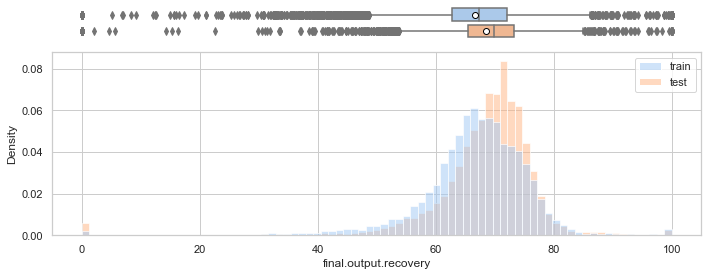

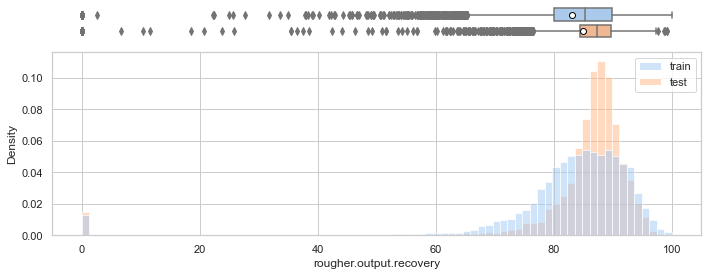

In [20]:
def feature_analyze(col_name='rougher.input.feed_size', bins=80, figsize=(10, 4)):
    f, (ax_box, ax_hist) = plt.subplots(2, figsize=figsize, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    a = df_train[col_name].to_frame().rename(columns={col_name:'train'})
    b = df_test[col_name].to_frame().rename(columns={col_name:'test'})
    c = pd.concat([a, b])
    c_melt = c.melt()
    bin_space = np.linspace(c_melt['value'].min(), c_melt['value'].max(), bins)
    sns.histplot(c, bins=bin_space, ax=ax_hist, stat='density', common_norm=False)
    sns.boxplot(data=c.melt(), x='value', y='variable', ax=ax_box, showmeans=True, meanprops={
            "marker":"o",
            "markerfacecolor":"white",
            "markeredgecolor":"black",
            "markersize":"6"})
    ax_hist.set(xlabel=col_name)
    ax_box.set_axis_off()
    f.tight_layout()
    plt.show()

feature_analyze('final.output.recovery')
feature_analyze('rougher.output.recovery')

Распределения похожи на нормальные - это хорошо. Но есть нюансы:
- в обоих распределениях есть заметный максимум в нуле. То есть при определенных условиях эффективность очистки оказывается нулевой. В частности, эти нулевые значения есть и в тестовой выборке!
- в эффективности финальной очистки есть максимум на 100%, что, вообще говоря, нефизично.

Можно отметить, что тестовые данные в целом лежат "внутри" обучающих, что хорошо - модель будет знакома с ожидаемым диапазоном результатов.

### Общий взгляд на фичи

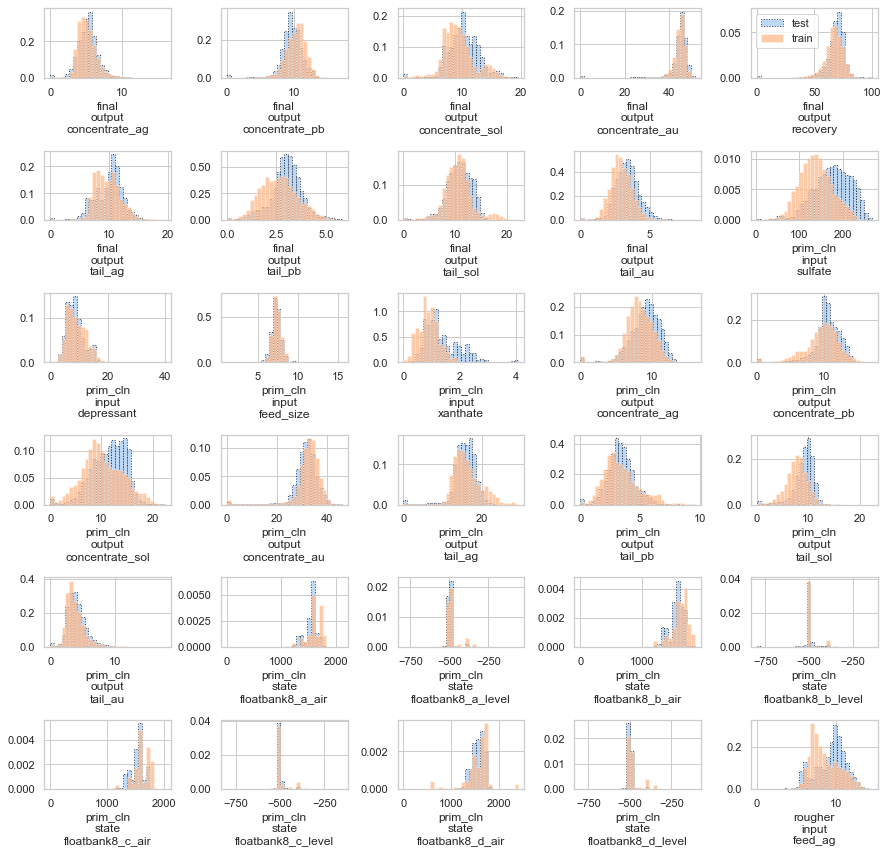

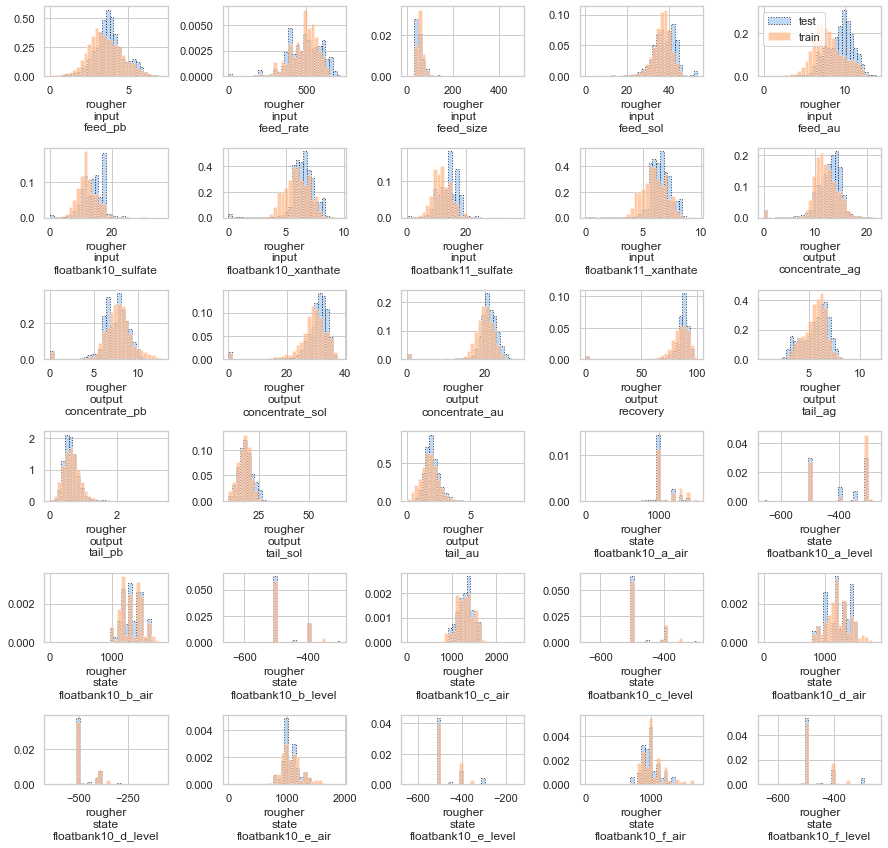

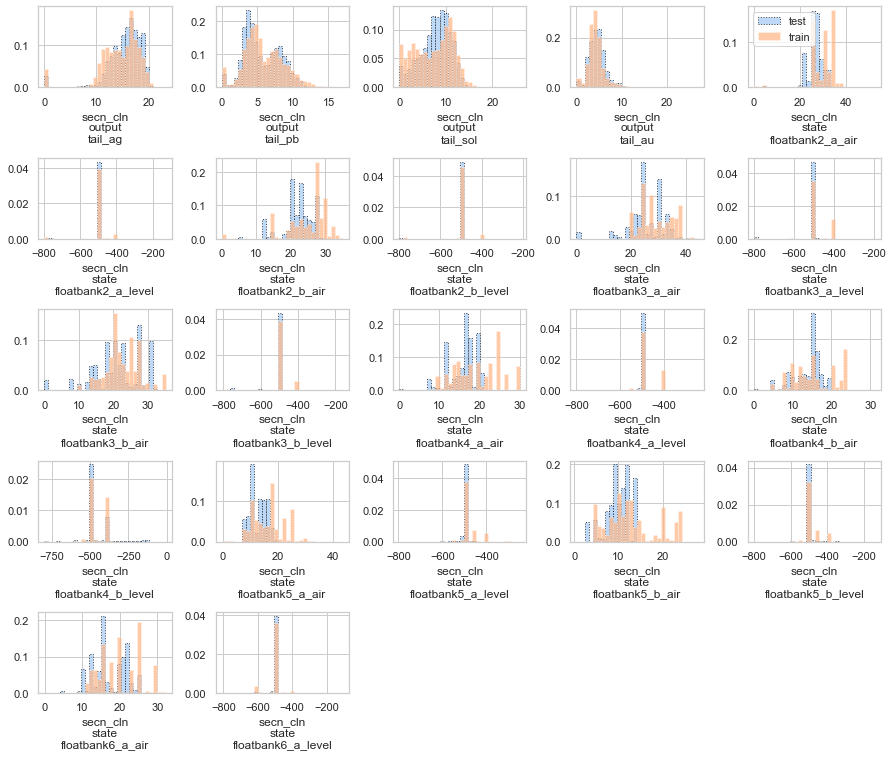

In [21]:
num_c = 5
num_r = 6
small_train = df_train

def plot_train_test_features(columns):
    fig = plt.figure(figsize=(num_c * 2.5, num_r * 2))
    for i, c in enumerate(columns):
        plt.subplot(num_r, num_c, i+1)
        bins=np.histogram(np.hstack((df_test[c].dropna(), small_train[c].dropna())), bins=30)[1]
        plt.hist(df_test[c], alpha=0.7, bins=bins, ls='dotted', label='test', edgecolor='black', density=True)
        plt.hist(small_train[c], alpha=0.7, bins=bins, ls='dotted', label='train', edgecolor='white', density=True)
        plt.xlabel('\n'.join(c.split('.')))
        if i == num_c - 1: plt.legend()
        if i >= 29: break
    plt.tight_layout()
    plt.show()

plot_train_test_features(df_test.columns[:30])
plot_train_test_features(df_test.columns[30:60])
plot_train_test_features(df_test.columns[60:])

Сразу сделаем несколько выводов:
- большинство фичей имеют не нормальное распределение
- у многих фичей распределение на обучении и тесте сильно отличается (сдвинут центр, сдвинут целиком диапазон и т.д.). То есть модель будет обучаться на данных, полученных в одних условиях, а применяться на данных, полученных в других условиях. Вероятно, это сильно ограничит ее применимость

### Изменение концентрации металлов по мере очистки

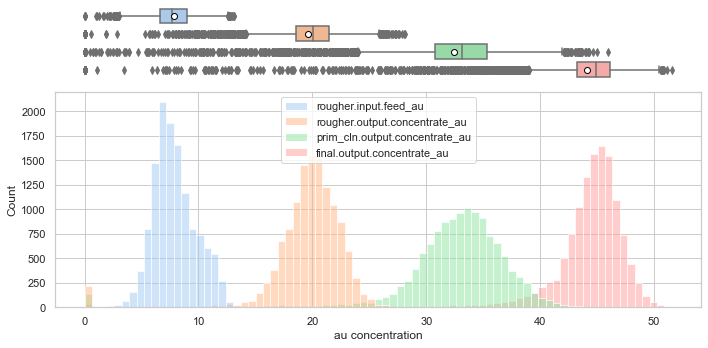

Средние значения:
- rougher.input.feed_au 8%
- rougher.output.concentrate_au 20%
- prim_cln.output.concentrate_au 32%
- final.output.concentrate_au 44%


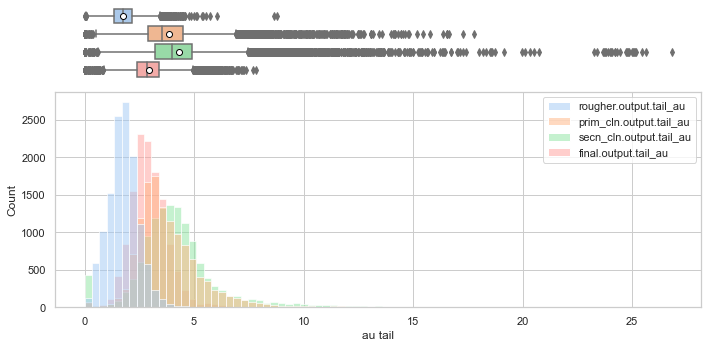

Средние значения:
- rougher.output.tail_au 2%
- prim_cln.output.tail_au 4%
- secn_cln.output.tail_au 4%
- final.output.tail_au 3%


In [22]:
def concentration_analyze(material='au', type='conc', bins=80, figsize=(10, 5)):
    f, (ax_box, ax_hist) = plt.subplots(2, figsize=figsize, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    if type  == 'conc':
        concentrate_list = ['rougher.input.feed_', 'rougher.output.concentrate_', 'prim_cln.output.concentrate_', 'final.output.concentrate_']
        xlabel = material + ' concentration'
    else:
        concentrate_list = ['rougher.output.tail_', 'prim_cln.output.tail_', 'secn_cln.output.tail_', 'final.output.tail_']
        xlabel = material + ' tail'
    concentrate_list = [i + material for i in concentrate_list]
    c = df_train[concentrate_list]
    c_melt = c.melt()
    bin_space = np.linspace(c_melt['value'].min(), c_melt['value'].max(), bins)
    sns.histplot(c, bins=bin_space, ax=ax_hist)
    sns.boxplot(data=c.melt(), x='value', y='variable', ax=ax_box, showmeans=True, meanprops={
            "marker":"o",
            "markerfacecolor":"white",
            "markeredgecolor":"black",
            "markersize":"6"})
    ax_hist.set(xlabel=xlabel)
    ax_box.set_axis_off()
    f.tight_layout()
    plt.show()

    print('Средние значения:')
    for c in concentrate_list:
        print('-', c, f'{df_train[c].mean():.0f}' + '%')

concentration_analyze()
concentration_analyze(type='tail')

Концентрация золота по мере очистки неуклонно растет. В среднем от 8% до 44%.

Наблюдается достаточно большой разброс концентраций, особенно, в меньшую сторону, вплоть до нуля.

Концентрация золота в отвалах обычно не превышает 10%

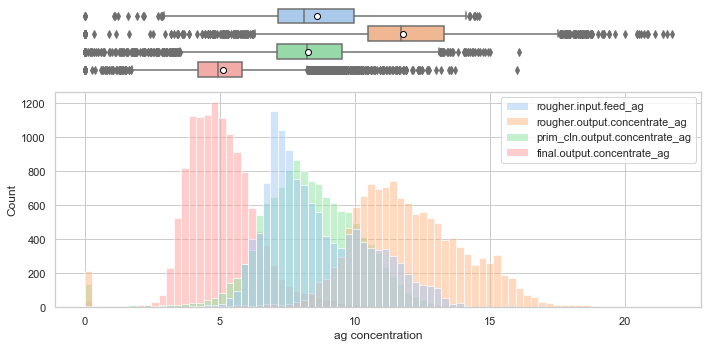

Средние значения:
- rougher.input.feed_ag 9%
- rougher.output.concentrate_ag 12%
- prim_cln.output.concentrate_ag 8%
- final.output.concentrate_ag 5%


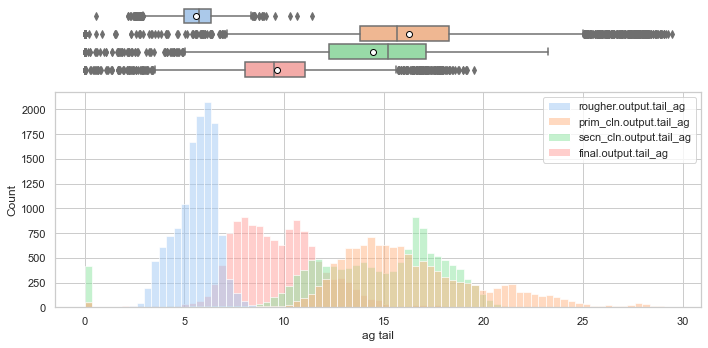

Средние значения:
- rougher.output.tail_ag 6%
- prim_cln.output.tail_ag 16%
- secn_cln.output.tail_ag 14%
- final.output.tail_ag 10%


In [23]:
concentration_analyze(material='ag')
concentration_analyze(material='ag', type='tail')

Концентрация серебра увеличивается в результате флотации и уменьшается на этапах очистки.

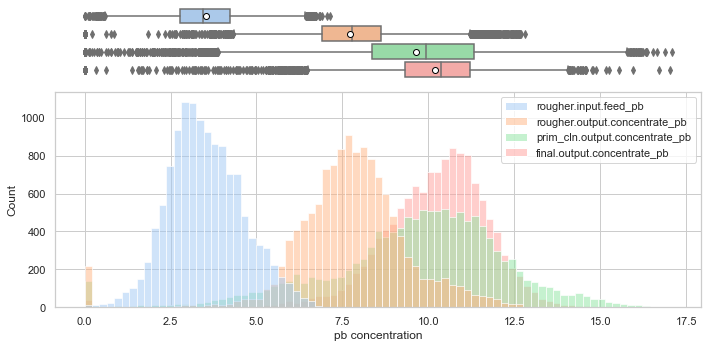

Средние значения:
- rougher.input.feed_pb 4%
- rougher.output.concentrate_pb 8%
- prim_cln.output.concentrate_pb 10%
- final.output.concentrate_pb 10%


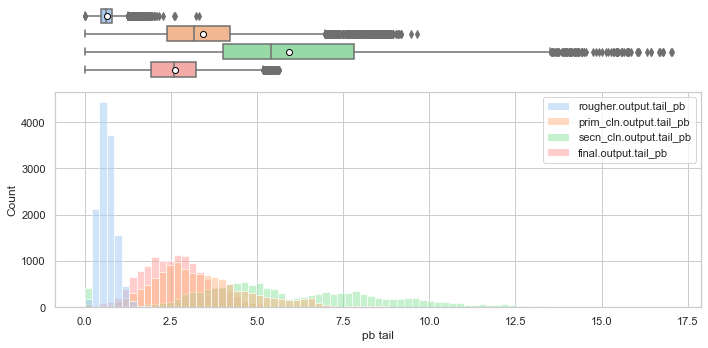

Средние значения:
- rougher.output.tail_pb 1%
- prim_cln.output.tail_pb 3%
- secn_cln.output.tail_pb 6%
- final.output.tail_pb 3%


In [24]:
concentration_analyze(material='pb')
concentration_analyze(material='pb', type='tail')

Концентрация свинца увеличивается на всех этапах очистки. Вероятно, это связано с тем, что молярная масса свинца близка к золоту.

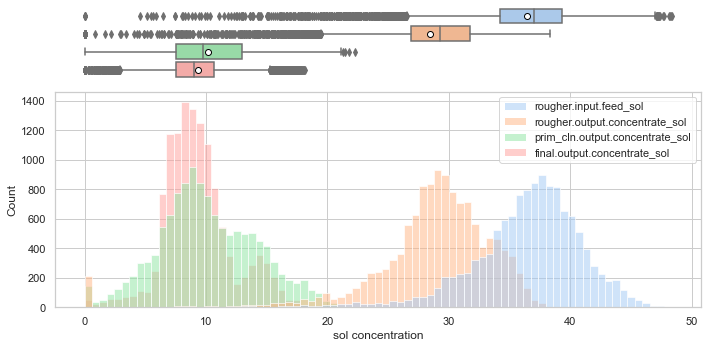

Средние значения:
- rougher.input.feed_sol 36%
- rougher.output.concentrate_sol 28%
- prim_cln.output.concentrate_sol 10%
- final.output.concentrate_sol 9%


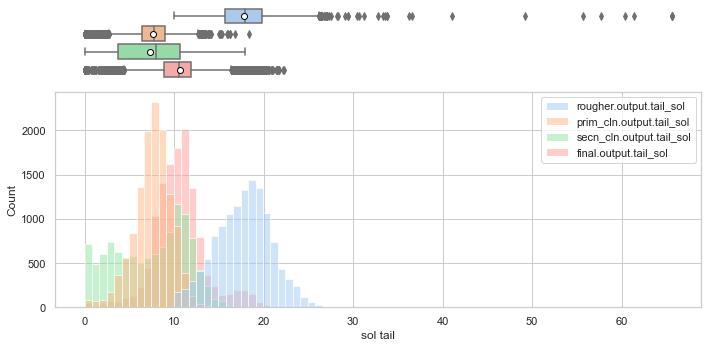

Средние значения:
- rougher.output.tail_sol 18%
- prim_cln.output.tail_sol 8%
- secn_cln.output.tail_sol 7%
- final.output.tail_sol 11%


In [25]:
concentration_analyze(material='sol')
concentration_analyze(material='sol', type='tail')

Концентрация золей систематически снижается по мере очистки.

### Размер гранул сырья

Сначала посмотрим на распределения размеров гранул сырья на входе в грубую очистку.

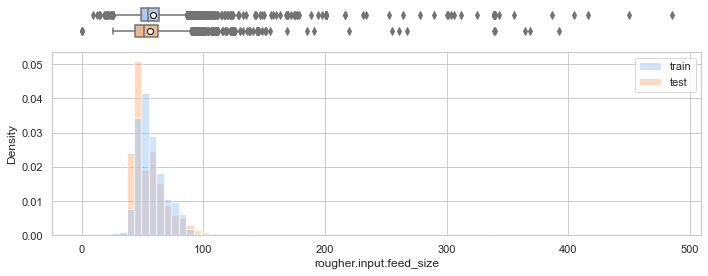

In [26]:
feature_analyze('rougher.input.feed_size')

Распределения - скошенные нормальные. Средние значения почти совпадают: 57 и 56.

Основные проблемы:
- близкие к нулю значения в тестовой выборке. Это очень опасно, потому что наша модель таких значений при обучении не увидит
- очень длинный хвост от 150 до 500. Содержит объекты как обучающей, так и тестовой выборок. Вероятно, для деревянных моделей не представляет опасности.

Теперь посмотрим на аналогичные распределения на входе в очиститель.

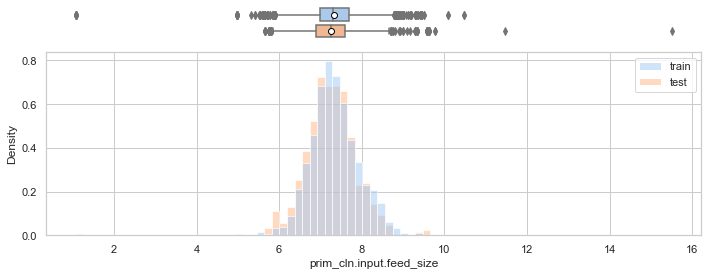

In [27]:
feature_analyze('prim_cln.input.feed_size')

- распределения близки к нормальным
- в обучающей выборке есть точки с сверхмалами значениями величины
- в тестовой выборке есть точки с сверхбольшими значениями величины. Может стать проблемой

Выводы:
- распределения размеров гранул в обучающей и тестовой выборках близки к нормальным. Средние значения и ширины распределения на выборках достаточно близки, поэтому предварительно можно сказать, что модель будет хорошо работать на тестовой выборке
- в тестовой выборке присутствуют выбросы в области, в которых нет данных из обучающей выборки. Это может создать проблему, особенно, при использовании линейных моделей. Для таких моделей, вероятно, следует обработать выбросы на тестовой выборке

### Суммарная концентрация веществ на различных этапах очистки

Нам даны сведения о концентрациях четырех веществ:
- золото
- серебро
- свинец
- золь

В идеальном случае их сумма должна была бы равняться 100%. Но, вероятно, в веществе присутствуют другие примеси. Исследуем распределения сумм этих веществ.

А теперь анализируем. Сначала данные о входных концентрациях.

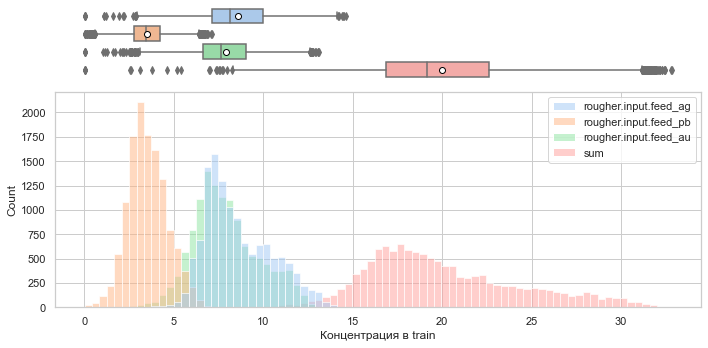

Концентрация в train 
Средние значения:
- rougher.input.feed_ag 9%
- rougher.input.feed_pb 4%
- rougher.input.feed_au 8%


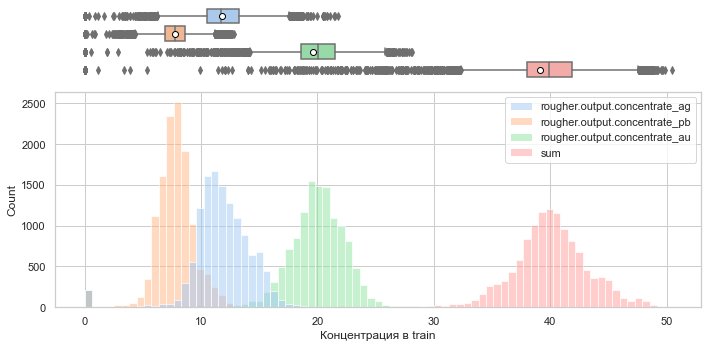

Концентрация в train 
Средние значения:
- rougher.output.concentrate_ag 12%
- rougher.output.concentrate_pb 8%
- rougher.output.concentrate_au 20%


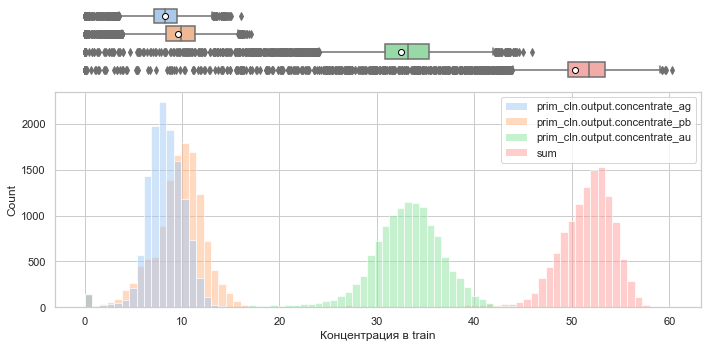

Концентрация в train 
Средние значения:
- prim_cln.output.concentrate_ag 8%
- prim_cln.output.concentrate_pb 10%
- prim_cln.output.concentrate_au 32%


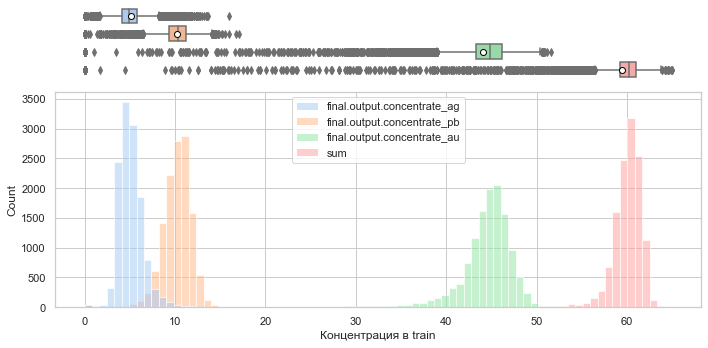

Концентрация в train 
Средние значения:
- final.output.concentrate_ag 5%
- final.output.concentrate_pb 10%
- final.output.concentrate_au 44%


In [28]:
def sum_concentration_analyze(stage='rougher', t='input', train=True, bins=80, figsize=(10, 5)):
    f, (ax_box, ax_hist) = plt.subplots(2, figsize=figsize, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    if train:
        df = df_train.copy()
    else:
        df = df_test.copy()
    cols = df.columns
    cols = [i for i in cols if stage in i and t in i and i[-2:] in ['ag', 'au', 'pb'] and 'tail' not in i]
    c = df[cols].copy()
    c['sum'] = c.sum(axis=1)
    c_melt = c.melt()
    bin_space = np.linspace(c_melt['value'].min(), c_melt['value'].max(), bins)
    sns.histplot(c, bins=bin_space, ax=ax_hist)
    sns.boxplot(data=c.melt(), x='value', y='variable', ax=ax_box, showmeans=True, meanprops={
            "marker":"o",
            "markerfacecolor":"white",
            "markeredgecolor":"black",
            "markersize":"6"})
    xlabel = 'Концентрация в ' + ('train' if train else 'test')
    ax_hist.set(xlabel=xlabel)
    ax_box.set_axis_off()
    f.tight_layout()
    plt.show()

    print(xlabel, '\nСредние значения:')
    for c in cols:
        print('-', c, f'{df_train[c].mean():.0f}' + '%')

sum_concentration_analyze(stage='rougher', t='input', train=True)
sum_concentration_analyze(stage='rougher', t='output', train=True)
sum_concentration_analyze(stage='prim_cln', t='output', train=True)
sum_concentration_analyze(stage='final', t='output', train=True)

Видим, как золото ползет вправо, а остальное (особенно, золи) - влево. Кроме того, видим, что в результате всей очистки остается прилично свинца. Объяснение - это тяжелый металл, который сложно чисто механически отделить от золота.

Кроме того, видим, что в данных есть большое количество выбросов. Так как многие методы уменьшают сумму квадратов ошибок, такие выбросы сильно испортят нам модель. А наша целевая метрика, напротив, более-менее устойчива к выбросам. Поэтому в дальнейшем из обучающей выборки будем удалять выбросы.

По результатам рассмотрения предлагаю убрать из обучающей выборки строки, в которых входные концентрации на флотацию малы - эти данные могут исказить работу моделей, при этом никак не помогут их работе. Посмотрим, сколько таких строк всего.

## Подготовка обучающей и тестовой выборок

Нам надо подготовить 8 массивов данных (отдельно фичи и отдельно таргет для каждой строки):
- обучающий для всего цикла
- тестовый для всего цикла
- обучающий для черновой очистки
- тестовый для черновой очистки

Чтобы было удобнее, каждую строку представим в виде словаря, в котром будут записаны фичи и таргеты.

Я задал уточняющий вопрос преподавателю, и он сказал, что нулевые значения целевого признака - это некорретные данные.

На таких данных нет смысла что-либо измерять, поэтому их надо почистить.

Кроме того, я не вижу в этих данных временного ряда, поэтому для адекватной кросс-валидации перемешал строки функцией sample.

In [29]:
feat = 'features'
targ = 'targets'

train_full = {}
test_full = {}
train_small = {}
test_small = {}

feat_cols = test_columns_list
feat_cols_small = [i for i in feat_cols if 'rougher' in i]

df_train1 = df_train.sample(frac=1) #добавим перемешивание - полезно для кросс-валидации
df_train1 = df_train1[df_train1['final.output.recovery'] > 0]
df_train1 = df_train1[df_train1['final.output.recovery'] < 100]
train_full[feat] = df_train1[feat_cols]
train_full[targ] = df_train1['final.output.recovery']

df_train2 = df_train.sample(frac=1) #добавим перемешивание - полезно для кросс-валидации
df_train2 = df_train2[df_train2['rougher.output.recovery'] > 0]
train_small[feat] = df_train2[feat_cols_small]
train_small[targ] = df_train2['rougher.output.recovery']

df_full1 = df_full.sample(frac=1)
test_full_df = df_full1[list(feat_cols) + ['final.output.recovery']].loc[df_test.index]
test_full_df = test_full_df[test_full_df['final.output.recovery'] > 0]
test_full_df = test_full_df[test_full_df['final.output.recovery'] < 100]
test_full[feat] = test_full_df[feat_cols]
test_full[targ] = test_full_df['final.output.recovery']

test_full_df = df_full1[list(feat_cols) + ['rougher.output.recovery']].loc[df_test.index]
test_full_df = test_full_df[test_full_df['rougher.output.recovery'] > 0]
test_small[feat] = test_full_df[feat_cols_small]
test_small[targ] = test_full_df['rougher.output.recovery']

for i, name in zip([train_full, test_full, train_small, test_small], ['train_full', 'test_full', 'train_small', 'test_small']):
    print('\n', name, 'shape (features / targets):')
    for j in [feat, targ]:
        print(i[j].shape, end='    ')


 train_full shape (features / targets):
(12605, 52)    (12605,)    
 test_full shape (features / targets):
(5234, 52)    (5234,)    
 train_small shape (features / targets):
(12469, 22)    (12469,)    
 test_small shape (features / targets):
(5193, 22)    (5193,)    

## Sanity check

Наша задача - минимизировать метрику sMAPE, усредненную с весами для двух предсказаний:
- эффективность флотации (вес 25%)
- эффективность финальной очистки (вес 75%)

То есть необходимо предсказать не одну, а две величины.

Никаких требований по скорости инференса нет.

Поэтому будем делать две независимые модели. На каждой будем выбирать архитектуру и гиперпараметры так, чтобы добиться минимального значения sMAPE. Так как модели независимы, минимизацию можно выполнять также независимо.

Начнем с самой бесполезной модели - выдачи медиан значений.

In [30]:
print('Стадия флотации:')
print(f'Метрика на всей обучающей выборке {calc_smape(train_small[targ], [train_small[targ].median()]*len(train_small[targ])):.4f}')
print('Стадия очистки:')
print(f'Метрика на всей обучающей выборке {calc_smape(train_full[targ], [train_full[targ].median()]*len(train_full[targ])):.4f}')

Стадия флотации:
Метрика на всей обучающей выборке 0.0705
Стадия очистки:
Метрика на всей обучающей выборке 0.0946


Любая модель, ошибка которой выше указанной, является бесполезной и совершенно неадекватной.

### Моделирование флотации

Нам необходимо минимиировать взвешенную сумму sMAPE предсказаний на тестовой выборке двух величин:
- final.output.recovery
- rougher.output.recovery

Наиболее эффективный способ сделать это - построить две модели, каждая из которых имеет свои входные фичи и свои гиперпараметры, и проводить оптимизацию независимо.

Начнем с моделирования процесса флотации - в нем меньше входных параметров. Кроме того, анализ этих параметров здесь позволит не анализировать их при построении модели офистки.

### Линейный бэйзлайн

Так как в задаче требуют обучить несколько моделей, попробуем начать с примитивного варианта - линейной регрессии c регуляризацией.

In [31]:
def linear_baseline(train_small):

    pipe = pipeline.Pipeline([
        ('Imputer', impute.SimpleImputer()),
        ('Scaler', preprocessing.RobustScaler()),
        ('LR', linear_model.Ridge())])

    param_distributions = {
        'Imputer__strategy': optuna.distributions.CategoricalDistribution(['mean', 'median', 'most_frequent']),
        'LR__alpha': optuna.distributions.LogUniformDistribution(1e-1, 1e3),
    }

    optuna_search = optuna.integration.OptunaSearchCV(
            pipe,
            param_distributions,
            cv=7,
            error_score=0,
            n_trials=1000,
            timeout=10,
            random_state=random_state,
            scoring=smape_score,
            n_jobs=-1,
            )

    optuna_search.fit(train_small[feat], train_small[targ])

    print("Количество запусков: {}".format(len(optuna_search.study_.trials)) + "\nЛучший результат:")
    print("- средняя метрика: {:.4f}".format(- optuna_search.study_.best_trial.value))
    parameters = optuna_search.best_params_
    print('- лучшие параметры', parameters)

    fig = plt.figure(figsize=(7, 7))
    p = optuna_search.predict(train_small[feat])
    ax = sns.scatterplot(x=train_small[targ], y=p)
    plt.plot([0, 100], [0, 100], color='red')
    ax.set(ylabel='Предсказанные значения на обучающей выборке')
    print(f'Метрика на всей обучающей выборке {calc_smape(train_small[targ], p):.4f}')

Количество запусков: 230
Лучший результат:
- средняя метрика: 0.0568
- лучшие параметры {'Imputer__strategy': 'most_frequent', 'LR__alpha': 119.29856369478799}
Метрика на всей обучающей выборке 0.0568


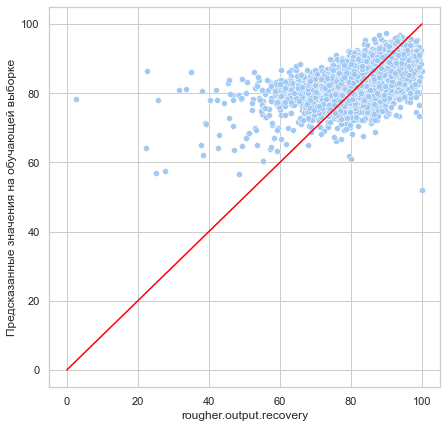

In [32]:
c = train_small[feat].columns
c = [i for i in c if 'rough' in i and ('feed' in i)]

linear_baseline({feat: train_small[feat][c],
                 targ: train_small[targ]
                 })

Таким образом, вот наш бэйзлайн - метрика на обучении, полученная на кросс-валидации, составляет 5.6%. Лучше, чем ответ константой.

Дальше попробуем сделать модель умнее.

### Выбор фич для моделирования

Сначала подготовим датафрейм без выбросов. Это нужно для оценки корреляции, потому что выбросы очень вредны для таких оценок.

In [33]:
c = pd.merge(train_small[feat],
         train_small[targ].to_frame(),
         left_index=True, right_index=True)
print('Количество фич в малой тренировочной выборке', len(train_small[feat].columns))
print('Количество строк в малой тренировочной выборке с выбросами', len(c))
for i in c.columns:
    q1, q3 = c[i].quantile(0.25), c[i].quantile(0.75)
    iqr = q3 - q1
    m1, m2 = q1 - iqr * 1.5, q3 + iqr * 1.5
    c = c[(c[i] >= m1) & (c[i] <= m2)]
print('Количество строк в малой тренировочной выборке без выбросов', len(c))

Количество фич в малой тренировочной выборке 22
Количество строк в малой тренировочной выборке с выбросами 12469
Количество строк в малой тренировочной выборке без выбросов 10262


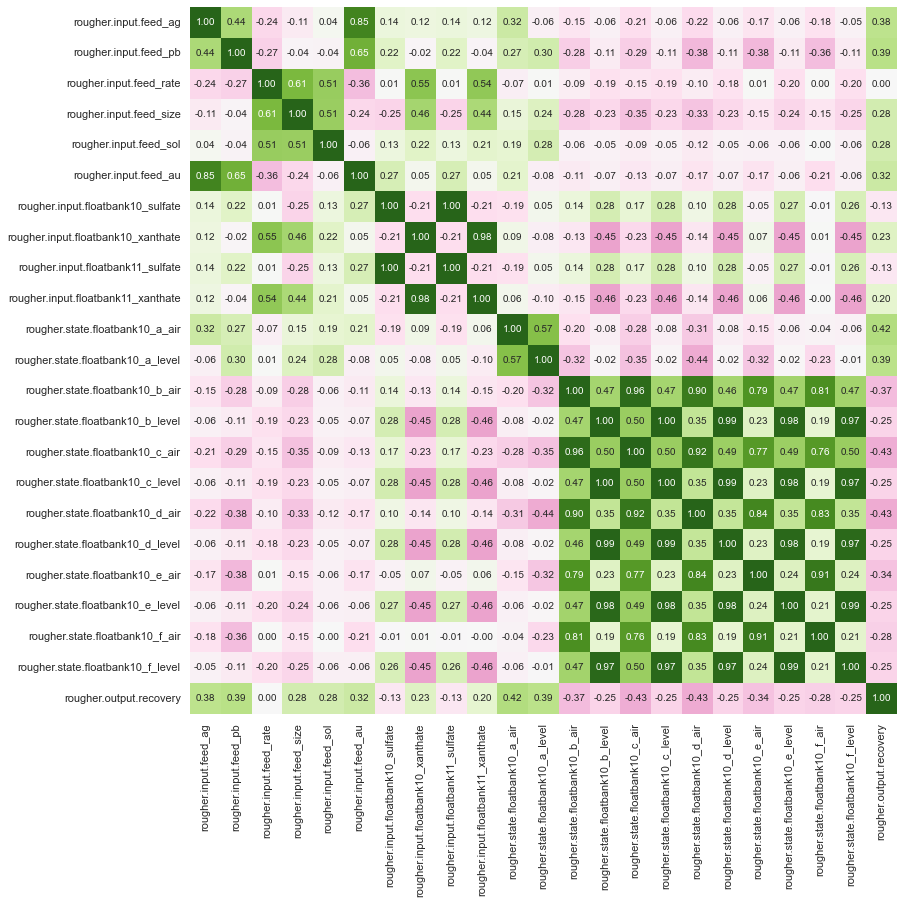

In [34]:
fig = plt.figure(figsize=(13,13))
sns.heatmap(c.corr(),
    square=True, cmap="PiYG",
    center=0,
    cbar=False,
    annot=True, fmt='.2f', annot_kws={'size': 10});

In [35]:
all_cols = [i for i in test_columns_list if 'rough' in i]
col_multi_1 = [i for i in all_cols if 'feed' in i and ('_ag' in i or '_au' in i)]
col_multi_2 = [i for i in all_cols if ('sulf' in i or 'xanth' in i)]
col_multi_3 = [i for i in all_cols if ('level' in i or 'air' in i) and ('_a_' not in i)]
col_other = list(set(all_cols) - set(col_multi_1) - set(col_multi_2) - set(col_multi_3))

Видим, что в данных есть сильно линейно коррелированные столбцы - "зеленые квадраты" на хитмапе. Вероятно, при моделировании стоит объединить такие столбцы, например, просуммировав их (потому что масштаб одинаковый) или использовав на них PCA.

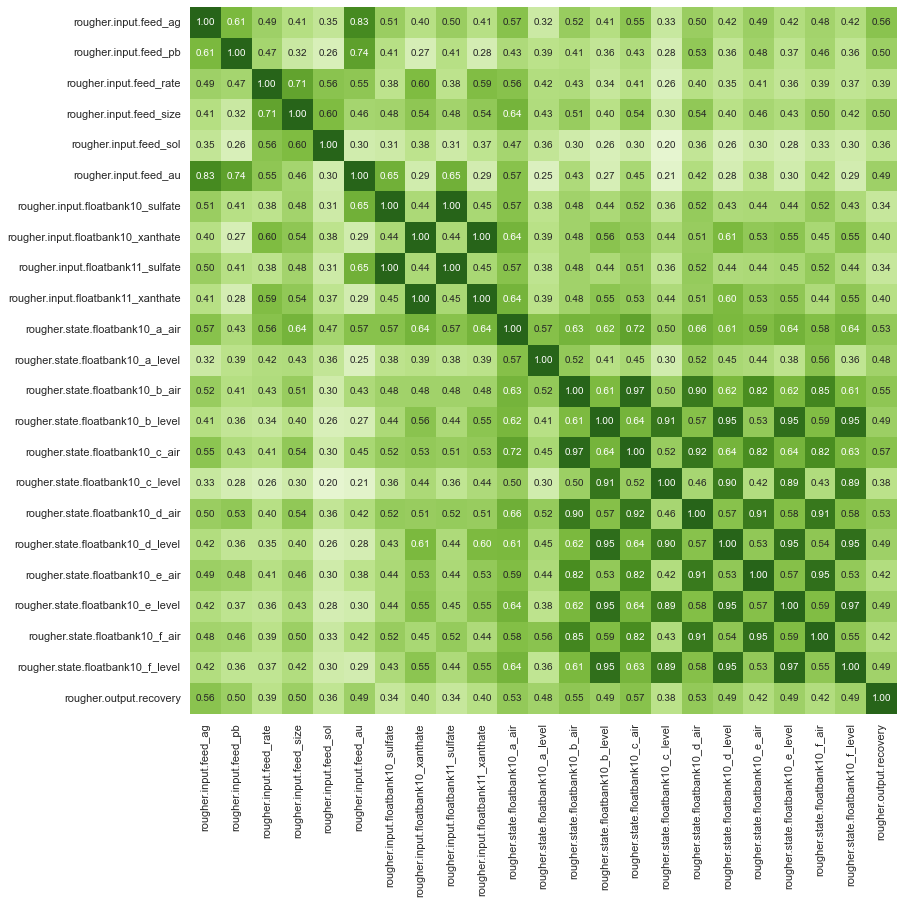

In [36]:
fig = plt.figure(figsize=(13,13))
sns.heatmap(data=c.phik_matrix(interval_cols=c.columns),
    square=True, cmap="PiYG",
    center=0,
    cbar=False,
    annot=True, fmt='.2f', annot_kws={'size': 10});

А тут видим, что практически все признаки имеют значимую нелинейную корреляцию с целевым. То есть просто так отбрасывать признаки было бы некорректно.

Выделим столбцы, входящие в "зеленые квадраты" и остальные столбцы.

Дальше сложно. Нам надо подобрать гиперпараметры модели с использованием кросс-валидации. Но есть нюанс: как было сказано выше, обучать мы планируем на сильно "почищенной" выборке, из которой удалены выбросы. А вот проверять скор надо бы на полной выборке, чтобы ожидать на тестовой выборке, содержащей много проблемных строк, аналогичный результат.

Для этого сделаем класс-обертку для произвольной модели, который будет выполнять разны типы препроцессинга на этапах обученя и инференса.

В идеале было бы здорово сделать это в виде пайплайна, но, как я понимаю, в пайплайне невозможно удалять строки из обучающей выборки на основе значений целевого признака.

In [37]:
SklearnInput = Union[list, np.ndarray, pd.DataFrame, pd.Series]

class model(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator: BaseEstimator, iqr_c=1.5, y_min=20, y_max=100, k=1, **kwargs: Any):
        self.estimator = estimator
        self.estimator.set_params(**kwargs)
        self.iqr_c = iqr_c
        self.limits = {}
        self.medians = {}
        self.y_min = y_min
        self.y_max = y_max
        self.k = k

    def fit(self, X: SklearnInput, y: SklearnInput, **fit_params: Any):
        df = pd.DataFrame(X, columns=all_cols)
        df['y'] = y
        for i in all_cols:
            q = 0.25
            m1, m2 = df[i].quantile(q), df[i].quantile(1-q)
            iqr = m2 - m1
            m1 = m1 - iqr * self.iqr_c
            m2 = m2 + iqr * self.iqr_c
            self.limits[i] = (m1, m2)
            df = df[df[i] >= m1]
            df = df[df[i] <= m2]
            self.medians[i] = df[i].median()

        df = df[df['y'] > self.y_min]
        df = df[df['y'] < self.y_max]
        
        x = df[all_cols]
        self.pca1 = PCA(1)
        self.pca2 = PCA(2)
        self.pca3 = PCA(2)
        self.pca1.fit(x[col_multi_1])
        self.pca2.fit(x[col_multi_2])
        self.pca3.fit(x[col_multi_3])

        x = np.hstack((x[col_other],
                       self.pca1.transform(x[col_multi_1]),
                       self.pca2.transform(x[col_multi_2]),
                       self.pca3.transform(x[col_multi_3])))
        
        self.scaler = preprocessing.RobustScaler()
        self.scaler.fit(x)
        x = self.scaler.transform(x)
        self.estimator.fit(X=x, y=df['y'], **fit_params)
        self.is_fit_ = True
        return self

    def predict(self, X: SklearnInput):
        check_is_fitted(self.estimator)
        df = pd.DataFrame(X, columns=all_cols)
        for i in all_cols:
            df.loc[df[i] < self.limits[i][0], i] = np.nan
            df.loc[df[i] > self.limits[i][1], i] = np.nan
            df[i] = df[i].fillna(self.medians[i])
            1;

        x = df[all_cols]
        x = np.hstack((x[col_other],
                       self.pca1.transform(x[col_multi_1]),
                       self.pca2.transform(x[col_multi_2]),
                       self.pca3.transform(x[col_multi_3])))
        x = self.scaler.transform(x)
        pred = self.estimator.predict(x) * self.k
        return pred

Количество запусков: 253
Лучший результат:
  метрика: -0.03060315079106891
{'estimator__n_estimators': 245, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.11663429785289285, 'estimator__min_child_weight': 2.9759950475778916, 'estimator__max_delta_step': 5.560722145028219, 'estimator__subsample': 0.9829922766857339, 'estimator__reg_lambda': 6.574426614654806, 'estimator__reg_alpha': 2.539452538468219e-06, 'estimator__colsample_bytree': 0.954433853556465, 'estimator__colsample_bylevel': 0.793044810325484, 'estimator__colsample_bynode': 0.93708679403193, 'iqr_c': 1.7852587453444422, 'y_min': 25.97741938921807, 'y_max': 98.3687123185569, 'k': 1.0010623246482808}
Метрика на всей обучающей выборке 0.0227


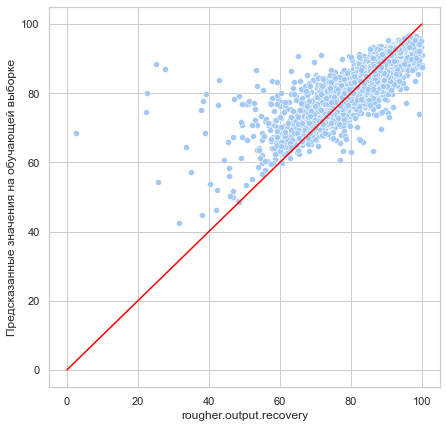

In [38]:
param_distributions = {
        'estimator__' + 'n_estimators': optuna.distributions.IntUniformDistribution(150, 300),
        'estimator__' + 'max_depth': optuna.distributions.IntUniformDistribution(3, 7),
        'estimator__' + 'learning_rate': optuna.distributions.LogUniformDistribution(5e-2, 5e-1),
        'estimator__' + 'min_child_weight': optuna.distributions.LogUniformDistribution(2e-0, 5e2),
        'estimator__' + 'max_delta_step': optuna.distributions.LogUniformDistribution(2e-0, 1e1),
        'estimator__' + 'subsample': optuna.distributions.UniformDistribution(0.6, 1),
        'estimator__' + 'reg_lambda': optuna.distributions.LogUniformDistribution(2e-2, 1e3),
        'estimator__' + 'reg_alpha': optuna.distributions.LogUniformDistribution(1e-7, 1e-4),
        'estimator__' + 'colsample_bytree': optuna.distributions.UniformDistribution(0.8, 1),
        'estimator__' + 'colsample_bylevel': optuna.distributions.UniformDistribution(0.7, 1),
        'estimator__' + 'colsample_bynode': optuna.distributions.UniformDistribution(0.9, 1),
        'iqr_c': optuna.distributions.UniformDistribution(1.3, 1.8),
        'y_min': optuna.distributions.UniformDistribution(15, 30),
        'y_max': optuna.distributions.UniformDistribution(98, 100),
        'k': optuna.distributions.UniformDistribution(0.98, 1.02),
    }

regressor = model(xgb.XGBRegressor())

optuna_search = optuna.integration.OptunaSearchCV(
        regressor,
        param_distributions,
        cv=5,
        n_trials=max_iter,
        timeout=timeout,
        random_state=random_state,
        scoring=smape_score,
        n_jobs=-1,
        refit=True,
        verbose=0
        )
optuna_search.fit(train_small[feat], train_small[targ])
print("Количество запусков: {}".format(len(optuna_search.study_.trials)))
print("Лучший результат:")
trial = optuna_search.study_.best_trial
print("  метрика: {}".format(trial.value))
parameters = optuna_search.best_params_
print(parameters)

fig = plt.figure(figsize=(7, 7))
p = optuna_search.predict(train_small[feat])
ax = sns.scatterplot(x=train_small[targ], y=p)
plt.plot([0, 100], [0, 100], color='red')
ax.set(ylabel='Предсказанные значения на обучающей выборке')
print(f'Метрика на всей обучающей выборке {calc_smape(train_small[targ], p):.4f}')

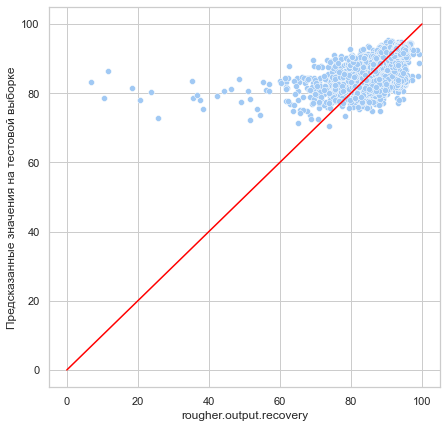

Количество предсказанных значений 5193
Метрика на тесте 0.0483759650615548


In [39]:
p = optuna_search.best_estimator_.predict(test_small[feat])
fig = plt.figure(figsize=(7, 7))
ax = sns.scatterplot(x=test_small[targ], y=p)
plt.plot([0, 100], [0, 100], color='red')
ax.set(ylabel='Предсказанные значения на тестовой выборке')
plt.show()
print('Количество предсказанных значений', len(p))
test_small_metric = calc_smape(test_small[targ], p)
print('Метрика на тесте', test_small_metric)

Отметим, что размер тестовой выборки не изменился с начала работы, как и должно быть.

Таким образом, получили метрику на тесте лучше, чем выдает линейный бэйзлайн.

### Расчет финишной эффективности

Повторим те же действия для расчета эффективности полной очистки.

Отмечу, что тут идея искать выбросы по принципу боксплота плохо работает. Поэтому я просто отбрасываю малые верхний и нижний квантили.

Количество запусков: 224
Лучший результат:
- средняя метрика: 0.0824
- лучшие параметры {'Imputer__strategy': 'mean', 'LR__alpha': 184.2042252894644}
Метрика на всей обучающей выборке 0.0823


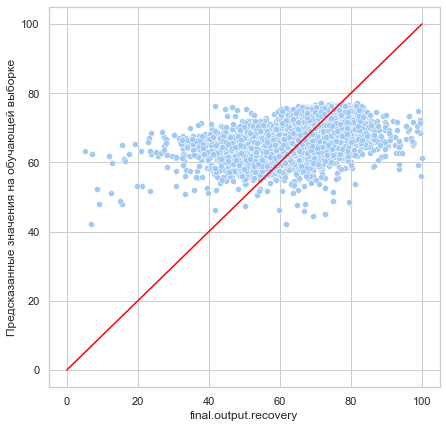

In [40]:
c = train_small[feat].columns
c = [i for i in c if 'rough' in i and ('feed' in i)]

linear_baseline({feat: train_full[feat][c],
                 targ: train_full[targ]
                 })

Метрика 8.2%. И опять - лучше, чем ответ константой.

### Выбор фич

Будем считать, что мы уже осуществили выбор фич для стадии rougher, поэтому их больше не будем анализировать.

In [41]:
c = pd.merge(train_full[feat].drop(columns=train_small[feat].columns),
         train_full[targ].to_frame(),
         left_index=True, right_index=True)
print('Количество фич в полной тренировочной выборке', len(train_full[feat].columns))
print('Количество фич без учета фич малой выборки', len(c.columns) - 1)
print('Количество строк в полной тренировочной выборке с выбросами', len(c))
for i in c.columns:
    if 'level' in i:
        q = 0.01
        m1, m2 = c[i].quantile(q), c[i].quantile(1-q)
    else:
        q1, q3 = c[i].quantile(0.25), c[i].quantile(0.75)
        iqr = q3 - q1
        k = 2.5
        m1, m2 = q1 - iqr * k, q3 + iqr * k
    c = c[(c[i] >= m1) & (c[i] <= m2)]
print('Количество строк в полной тренировочной выборке без выбросов', len(c))

Количество фич в полной тренировочной выборке 52
Количество фич без учета фич малой выборки 30
Количество строк в полной тренировочной выборке с выбросами 12605
Количество строк в полной тренировочной выборке без выбросов 8466


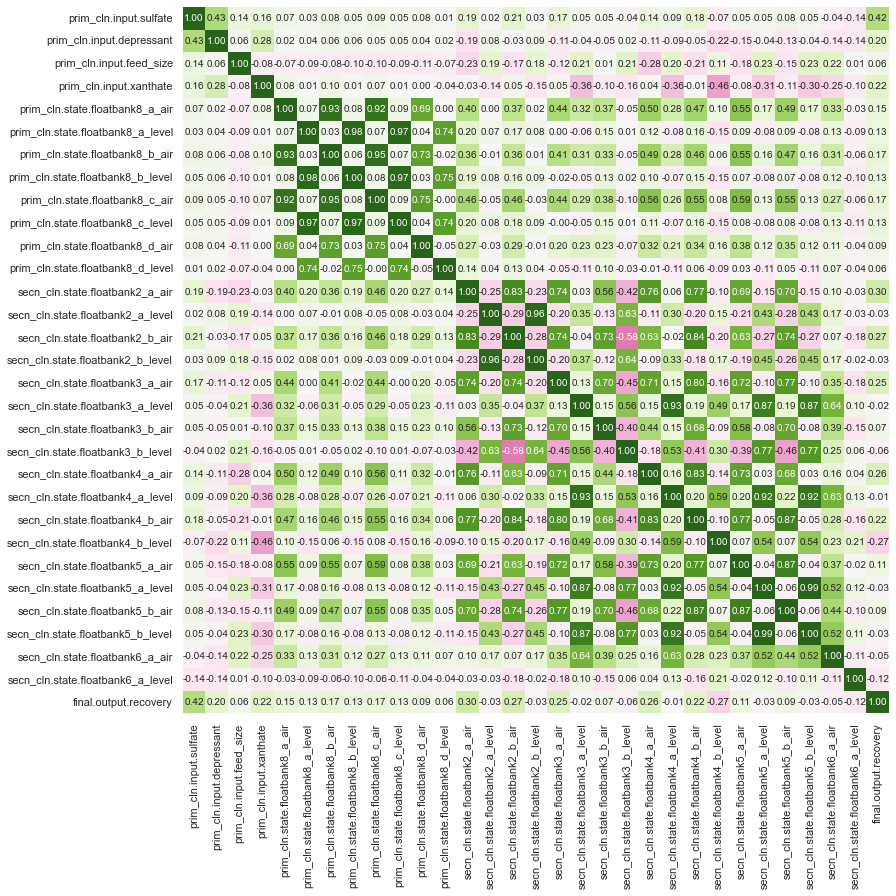

In [42]:
fig = plt.figure(figsize=(13,13))
sns.heatmap(c.corr(),
    square=True, cmap="PiYG",
    center=0,
    cbar=False,
    annot=True, fmt='.2f', annot_kws={'size': 10});

И опять видим "квадраты коллинеарности", которые стоит сшить методом главных компонент.

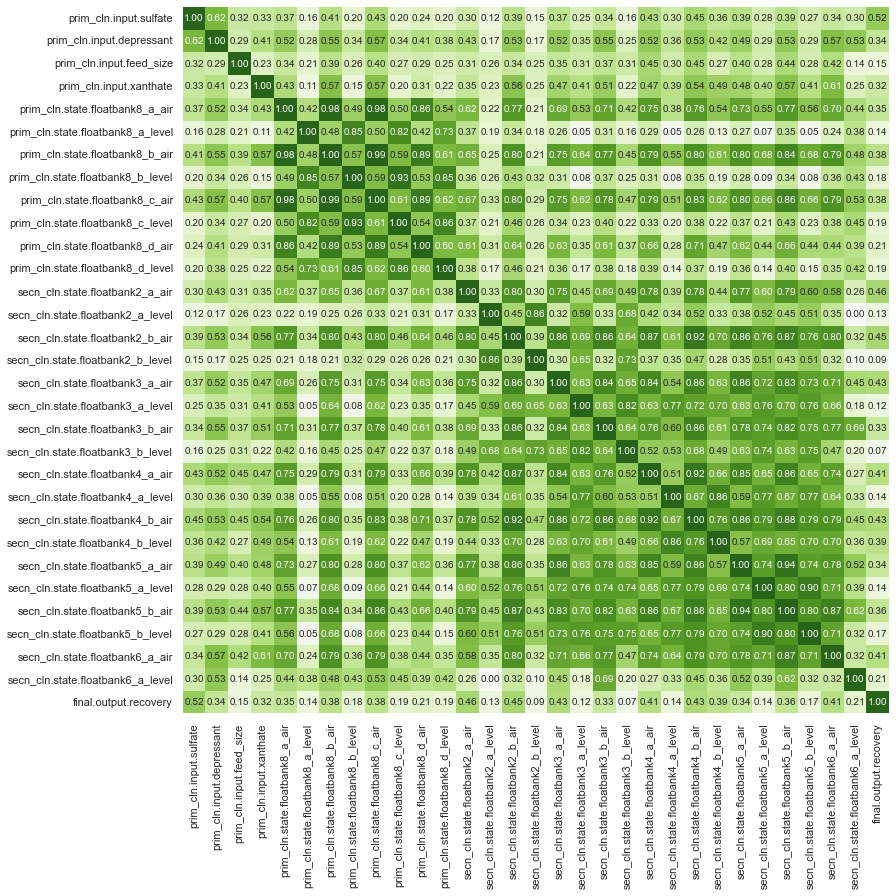

In [43]:
fig = plt.figure(figsize=(13,13))
sns.heatmap(data=c.phik_matrix(interval_cols=c.columns),
    square=True, cmap="PiYG",
    center=0,
    cbar=False,
    annot=True, fmt='.2f', annot_kws={'size': 10});

Видим, что есть ряд признаков, которые, на первый взгляд, играют минимальную роль:
- feed size
- все level

Предлагаю их просто выкинуть из рассмотрения.

In [44]:
all_cols_full = test_columns_list
all_cols_add = [i for i in test_columns_list if 'rough' not in i]
col_multi_4 = [i for i in all_cols_add if 'air' in i]
col_other_2 = [i for i in all_cols_add if 'input' in i and 'size' not in i]
needed_columns = col_multi_1 + col_multi_2 + col_multi_3 + col_other + col_multi_4 + col_other_2

Опять сделаем навороченный класс модели. Еще более навороченный.

In [45]:
SklearnInput = Union[list, np.ndarray, pd.DataFrame, pd.Series]

class model_full(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator: BaseEstimator, iqr_c=1.5, q=0.01, y_min=20, y_max=100, k=1, **kwargs: Any):
        self.estimator = estimator
        self.estimator.set_params(**kwargs)
        self.iqr_c = iqr_c
        self.limits = {}
        self.medians = {}
        self.y_min = y_min
        self.y_max = y_max
        self.k = k
        self.q = q

    def fit(self, X: SklearnInput, y: SklearnInput, **fit_params: Any):
        df = pd.DataFrame(X, columns=all_cols_full)
        df = df[needed_columns]
        df['y'] = y
        for i in needed_columns:
            #q_lim = 0.25
            #m1, m2 = df[i].quantile(q_lim), df[i].quantile(1-q_lim)
            #iqr = m2 - m1
            #m1 = m1 - iqr * self.iqr_c
            #m2 = m2 + iqr * self.iqr_c
            m1, m2 = df[i].quantile(self.q), df[i].quantile(1-self.q)
            self.limits[i] = (m1, m2)
            df = df[df[i] >= m1]
            df = df[df[i] <= m2]
            self.medians[i] = df[i].median()

        df = df[df['y'] > self.y_min]
        df = df[df['y'] < self.y_max]

        x = df[needed_columns]
        self.pca1 = PCA(1)
        self.pca2 = PCA(2)
        self.pca3 = PCA(2)
        self.pca4 = PCA(1)
        self.pca1.fit(x[col_multi_1])
        self.pca2.fit(x[col_multi_2])
        self.pca3.fit(x[col_multi_3])
        self.pca4.fit(x[col_multi_4])

        x = np.hstack((x[col_other],
                       x[col_other_2],
                       self.pca1.transform(x[col_multi_1]),
                       self.pca2.transform(x[col_multi_2]),
                       self.pca3.transform(x[col_multi_3]),
                       self.pca4.transform(x[col_multi_4])
        ))

        self.scaler = preprocessing.RobustScaler()
        self.scaler.fit(x)
        x = self.scaler.transform(x)
        self.estimator.fit(X=x, y=df['y'], **fit_params)
        self.is_fit_ = True
        return self

    def predict(self, X: SklearnInput):
        check_is_fitted(self.estimator)
        df = pd.DataFrame(X, columns=all_cols_full)
        df = df[needed_columns]
        for i in needed_columns:
            df.loc[df[i] < self.limits[i][0], i] = np.nan
            df.loc[df[i] > self.limits[i][1], i] = np.nan
            df[i] = df[i].fillna(self.medians[i])
            1;

        x = df[needed_columns]
        x = np.hstack((x[col_other],
                       x[col_other_2],
                       self.pca1.transform(x[col_multi_1]),
                       self.pca2.transform(x[col_multi_2]),
                       self.pca3.transform(x[col_multi_3]),
                       self.pca4.transform(x[col_multi_4])
        ))
        x = self.scaler.transform(x)
        pred = self.estimator.predict(x) * self.k
        return pred

Количество запусков: 244
Лучший результат:
  метрика: -0.06591082565144656
{'estimator__n_estimators': 281, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.10885398231751273, 'estimator__min_child_weight': 6.0546786457363595, 'estimator__max_delta_step': 6.217120577786684, 'estimator__subsample': 0.8291754614121898, 'estimator__reg_lambda': 45.43818734978393, 'estimator__reg_alpha': 1.4843991489515776e-05, 'estimator__colsample_bytree': 0.9543380795262084, 'estimator__colsample_bylevel': 0.7684346172986036, 'estimator__colsample_bynode': 0.9083118748532483, 'iqr_c': 1.5992724170794312, 'y_min': 29.90876446864225, 'y_max': 98.9380922449682, 'k': 1.0065629389957942}
Метрика на всей обучающей выборке 0.0565


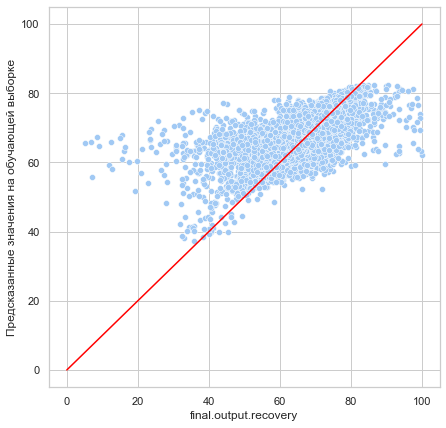

In [46]:
param_distributions = {
        'estimator__' + 'n_estimators': optuna.distributions.IntUniformDistribution(150, 300),
        'estimator__' + 'max_depth': optuna.distributions.IntUniformDistribution(3, 7),
        'estimator__' + 'learning_rate': optuna.distributions.LogUniformDistribution(5e-2, 5e-1),
        'estimator__' + 'min_child_weight': optuna.distributions.LogUniformDistribution(2e-0, 5e2),
        'estimator__' + 'max_delta_step': optuna.distributions.LogUniformDistribution(2e-0, 1e1),
        'estimator__' + 'subsample': optuna.distributions.UniformDistribution(0.6, 1),
        'estimator__' + 'reg_lambda': optuna.distributions.LogUniformDistribution(2e-2, 1e3),
        'estimator__' + 'reg_alpha': optuna.distributions.LogUniformDistribution(1e-7, 1e-4),
        'estimator__' + 'colsample_bytree': optuna.distributions.UniformDistribution(0.8, 1),
        'estimator__' + 'colsample_bylevel': optuna.distributions.UniformDistribution(0.7, 1),
        'estimator__' + 'colsample_bynode': optuna.distributions.UniformDistribution(0.9, 1),
        'iqr_c': optuna.distributions.UniformDistribution(1.3, 1.8),
        'y_min': optuna.distributions.UniformDistribution(15, 30),
        'y_max': optuna.distributions.UniformDistribution(98, 100),
        'k': optuna.distributions.UniformDistribution(0.98, 1.02),
    }

regressor = model_full(xgb.XGBRegressor())

optuna_search = optuna.integration.OptunaSearchCV(
        regressor,
        param_distributions,
        cv=5,
        n_trials=max_iter,
        timeout=timeout,
        random_state=random_state,
        scoring=smape_score,
        n_jobs=-1,
        refit=True,
        verbose=0
        )
optuna_search.fit(train_full[feat], train_full[targ])
print("Количество запусков: {}".format(len(optuna_search.study_.trials)))
print("Лучший результат:")
trial = optuna_search.study_.best_trial
print("  метрика: {}".format(trial.value))
parameters = optuna_search.best_params_
print(parameters)

fig = plt.figure(figsize=(7, 7))
p = optuna_search.predict(train_full[feat])
ax = sns.scatterplot(x=train_full[targ], y=p)
plt.plot([0, 100], [0, 100], color='red')
ax.set(ylabel='Предсказанные значения на обучающей выборке')
print(f'Метрика на всей обучающей выборке {calc_smape(train_full[targ], p):.4f}')

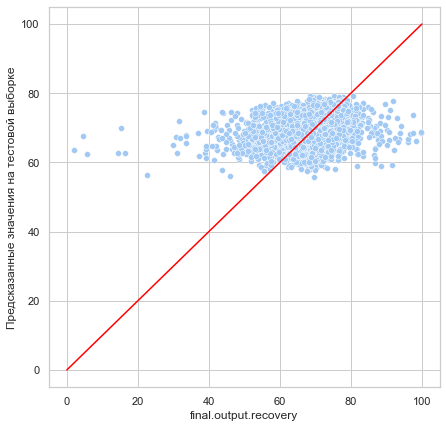

Количество предсказанных значений 5234
Метрика на тесте 0.07893260673100291


In [47]:
p = optuna_search.best_estimator_.predict(test_full[feat])
fig = plt.figure(figsize=(7, 7))
ax = sns.scatterplot(x=test_full[targ], y=p)
plt.plot([0, 100], [0, 100], color='red')
ax.set(ylabel='Предсказанные значения на тестовой выборке')
plt.show()
print('Количество предсказанных значений', len(p))
test_full_metric = calc_smape(test_full[targ], p)
print('Метрика на тесте', test_full_metric)

Напомним, что метрика на константном ответе была 9,5%, а на линейной модели - 8.2%. То есть мы чуть-чуть улучшили результат.

Теперь посмотрим на взвешенную метрику!

In [48]:
a = test_full_metric * 0.75 + test_small_metric * 0.25
print('взвешенная sMAPE =', a)

взвешенная sMAPE = 0.07129344631364089


## Выводы

- проведен анализ данных в соответствии с ТЗ
    - эффективность обогащения rougher.output.recovery в исходных данных рассчитана верно
    - в тестовой выборке недоступны признаки, соответствующие типам: output и calculation, то есть результаты технологических операций и какие-то промежуточные расчеты, которые получаются на основе технологических данных
    - проведена предобработка данных - из обучающей выборки удалены строки с пропусками. Более серьезная предобработка проведена на этапе моделирования
- проведен анализ данных
    - концентрация золота по мере обогащения систематически увеличивается
    - концентрации серебра и свинца изменяются, но нет систематического тренда. На этапе финишной очистки эти концентрации снижаются
    - размеры гранул сырья на обучающей и тестовой выборках лежат в одном диапазоне, средние значения совпадают, формы распределений различаются, но незначительно
    - суммарная концентрация всех веществ на всех этапах очистки слабо увеличивается от 55% на входе до 70% на выходе
- при помощи кросс-валидации обучены отдельные модели для предсказания эффективности процессов флотации и очистки. Для каждого процесса обучено по 1 линейной и 1 нелинейной модели. Нелинейные модели показали более малые значения sMAPE
- было получено итоговое взвешенное значение метрики sMAPE